# Libary imports

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import geoplot as gplt
import geopandas as gpd
import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
from esda.moran import Moran
from libpysal.weights import Queen
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier

# Set seed

In [3]:
np.random.seed(123456)

# Load the DataFrames

In [2]:
df_full = pd.read_csv('city_spatial_rs_full_geom.csv')
df_withCitiesNames = pd.read_csv('city_spatial_rs.csv')
df_withoutCityNames = df_withCitiesNames.drop(['UC_NM_MN','XC_NM_LST'], axis=1)
df_full['geometry'] = gpd.GeoSeries.from_wkt(df_full['geometry'])
geo_df_full = gpd.GeoDataFrame(df_full, geometry='geometry')
variables = df_withoutCityNames.columns.to_list()
variables.append("geometry")
geo_df = geo_df_full[variables]
w = Queen.from_dataframe(geo_df)
df = geo_df.drop(['geometry'], axis=1)

C:\Users\pbeek\AppData\Local\Temp\ipykernel_31920\629691616.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(geo_df)


In [5]:
for i in df.columns: 
    df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())

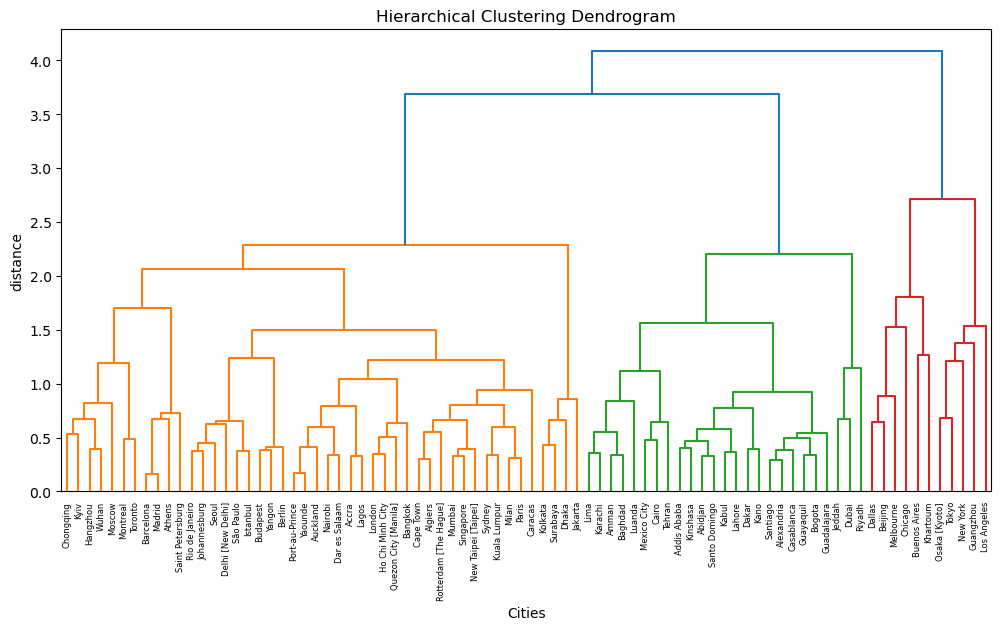

In [6]:
#Following code was isnpired from: https://jbhender.github.io/Stats506/F18/GP/Group15.html

linked = linkage(df, 'ward')
plt.figure(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cities')
plt.ylabel('distance')
dendrogram(linked,
           orientation='top',
           labels=df_full['UC_NM_MN'].values,
           distance_sort='descending',
           color_threshold= None,
           show_leaf_counts=True)
plt.show()

In [7]:
data = df
linkage = 'ward'
N = 25
WSS_n = []
for i in range(1,N):
    cluster = AgglomerativeClustering(n_clusters= i, linkage=linkage,connectivity=w.sparse)
    cluster.fit_predict(data)
    label = cluster.labels_
    wss = []
    for j in range(i+1):
        idx = [t for t, e in enumerate(label) if e == j]
        cluster = data.iloc[idx,]
        cluster_mean = cluster.mean(axis=0)
        distance = np.sum(np.abs(cluster - cluster_mean)**2)
        wss.append(sum(distance))
    WSS_n.append(sum(wss))



c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axi

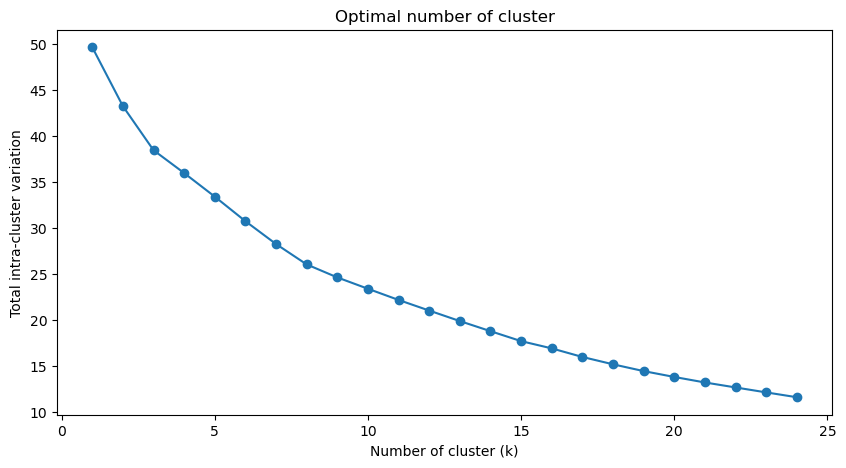

In [8]:
cluster_range = range(1, 25)
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster (k)')
plt.ylabel('Total intra-cluster variation')
plt.plot(cluster_range, WSS_n, marker = "o")

In [9]:
cluster = AgglomerativeClustering(n_clusters=10, linkage='ward')
model =  cluster.fit_predict(data)


In [10]:
# the following code is from
# [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/]
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(14,8))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [11]:
cmap = cm.get_cmap('tab10').colors
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

C:\Users\jelte\AppData\Local\Temp\ipykernel_14436\2368038904.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10').colors


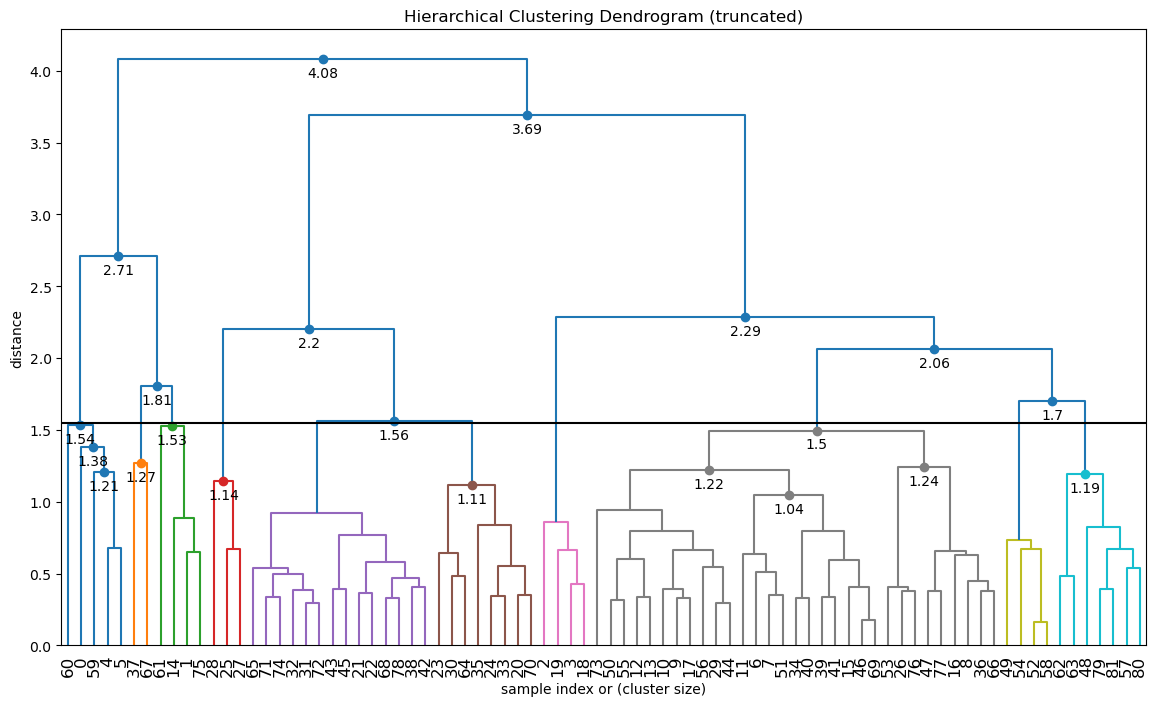

In [12]:
fancy_dendrogram(
    linked,
    truncate_mode=None,
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d = 1.55, 
)

plt.show()

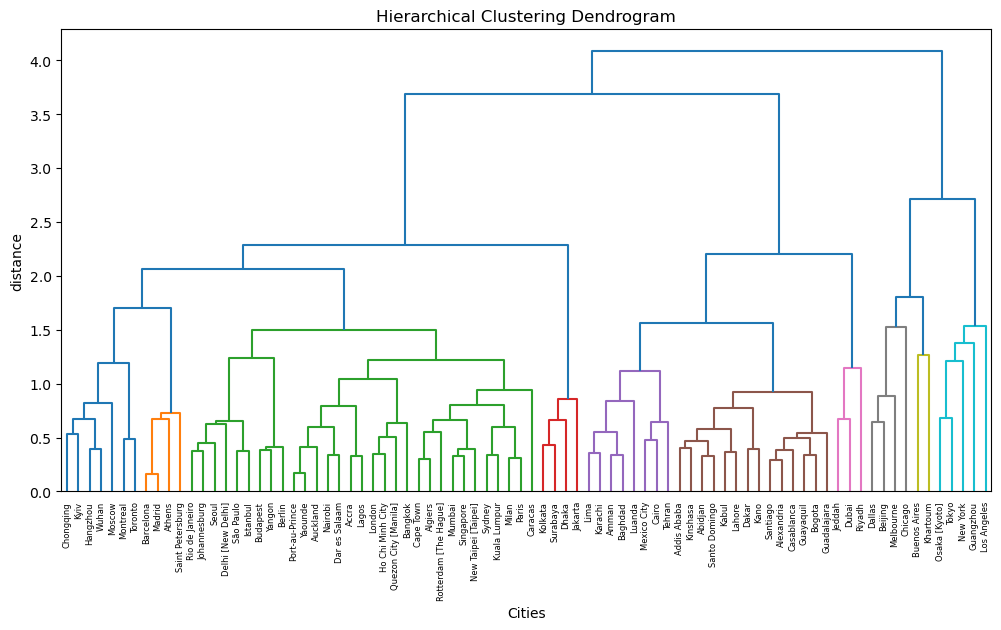

In [13]:

plt.figure(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cities')
plt.ylabel('distance')
dendrogram(linked,
           orientation='top',
           labels=df_full['UC_NM_MN'].values,
           distance_sort='descending',
           color_threshold= 1.55,
           show_leaf_counts=True,)
plt.show()

# Feature importance
## Fit Random forest model
This model helps with calculating the feature importances

In [14]:
rf = RandomForestClassifier()
rf.fit(df, cluster.labels_)

RandomForestClassifier()

## Calculate the actual Feature importance values

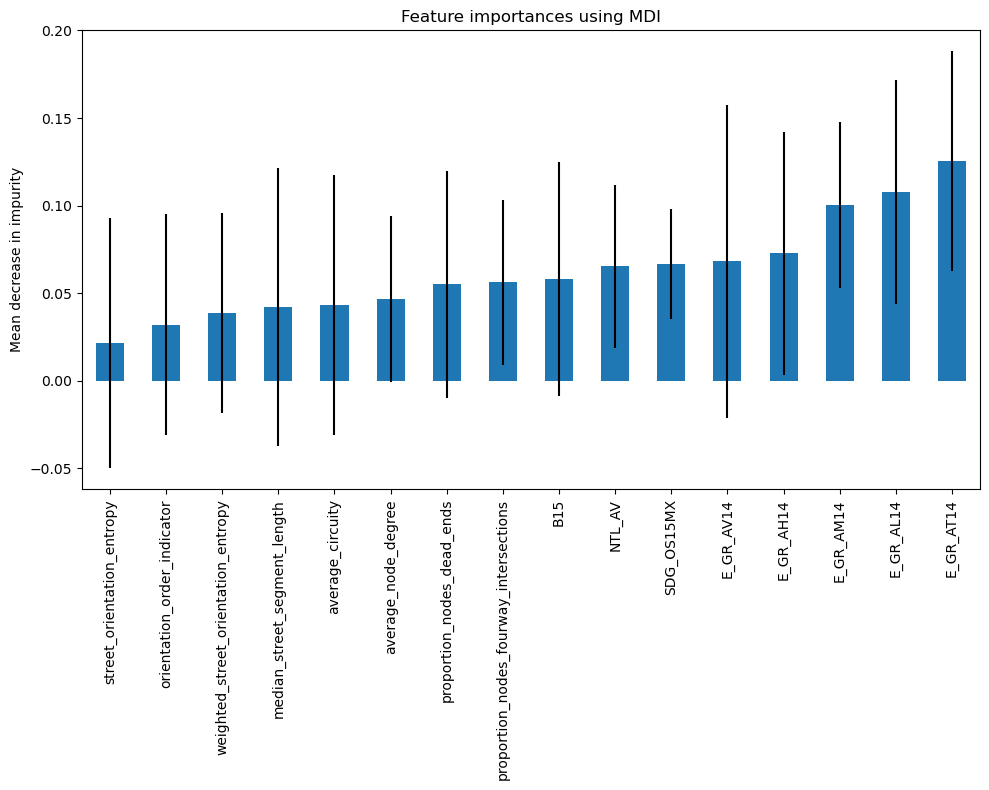

In [15]:
# Create a list with the feature names
feature_names = df.columns.to_list()
# Calculate the feature importance values
importances = rf.feature_importances_
# Sort the feature importances from low to high
sorted = importances.argsort()
# Calculate the standard deviation for each feature
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances[sorted], index=feature_names)

# Create the feature importance plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, figsize= (10,8))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [16]:
cluster.labels_.size

82

c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\geoplot\geoplot.py:1659: UserWarning: "webmap" is only compatible with the "WebMercator" projection, but the input projection is unspecified. Reprojecting the data to "WebMercator" automatically. To suppress this warning, set "projection=gcrs.WebMercator()" explicitly.
  warnings.warn(
c:\Users\jelte\anaconda3\envs\GeoSpatial\Lib\site-packages\geoplot\geoplot.py:708: UserWarning: Could not set plot extent successfully due to numerical instability. Try setting extent manually. Defaulting to a global extent.
  warnings.warn(

<GeoAxes: >

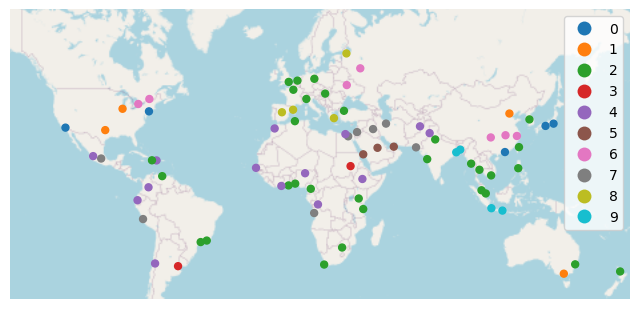

In [20]:
geo_df['labels'] = cluster.labels_
world = gpd.read_file("maps/ne_110m_land.shp")
ax = gplt.webmap(world)

gplt.pointplot(geo_df, ax =ax, hue = 'labels' , cmap = 'tab10', legend='full', scheme = 'categorical')
